In [1]:
import os
os.chdir("..")

In [25]:
import multi_agent_reinforcement_learning
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import lognorm
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [3]:
with open("data/scenario_nyc_brooklyn.json") as f:
    data = json.loads(f.read())

In [5]:
df = pd.DataFrame(data["demand"])

In [6]:
df.head()

,time_stamp,origin,destination,demand,travel_time,price
0,1170,6,7,0.133333,16,19.4
1,1170,5,13,0.066667,22,46.8
2,1170,12,6,0.866667,20,35.7
3,1170,5,6,0.600000,34,55.0
4,1170,6,1,0.133333,10,17.8


# Simple summary stats

In [7]:
df_org_dest = df.groupby(["origin", "destination"]).agg({"price": ["count", "mean"], "demand": "mean", "travel_time":"mean"}).reset_index()

In [8]:
df_org_dest.head()

origin destination price               demand travel_time
                     count       mean      mean        mean
0      1           6   105  15.071429  0.066667   13.857143
1      2           6    15   7.500000  0.066667    6.000000
2      5           0   105  46.028571  0.095238   23.857143
3      5           1   150  50.880000  0.113333   33.800000
4      5           2   135  37.644444  0.111111   24.777778

In [9]:
df_org_dest.columns = df_org_dest.columns.droplevel(0)
df_org_dest.columns = ["org", "dest", "count", "mean_price", "mean_demand", "mean_travel_time"]

In [10]:
df.describe()

,time_stamp,origin,destination,demand,travel_time,price
count,4830.000000,4830.000000,4830.000000,4830.000000,4830.00000,4830.000000
mean,1228.288820,7.844720,7.319876,0.218219,19.42236,29.618012
std,51.704759,3.155839,3.639388,0.270394,8.86647,15.159487
min,1140.000000,1.000000,0.000000,0.066667,5.00000,7.500000
25%,1183.000000,5.000000,5.000000,0.066667,12.00000,17.500000
50%,1229.500000,6.000000,8.000000,0.133333,18.00000,27.000000
75%,1272.000000,11.000000,10.000000,0.200000,25.00000,40.300000
max,1319.000000,13.000000,13.000000,2.000000,68.00000,75.600000


In [48]:
np.sort(df.destination.unique())

array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [47]:
np.sort(df.origin.unique())

array([ 1,  2,  5,  6,  7,  8,  9, 10, 11, 12, 13])

# Grid analysis

In [11]:
pivot_df = df_org_dest.pivot(index='org', columns='dest', values='count')

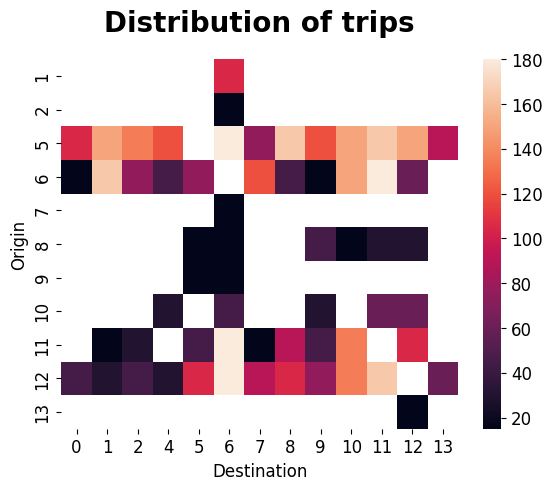

In [12]:
sns.heatmap(pivot_df, annot=False, fmt="d")
plt.title('Distribution of trips')
plt.xlabel('Destination')
plt.ylabel('Origin')
plt.show()

In [16]:
mean_demand_matrix = df.groupby("origin")["demand"].mean().values.reshape(1,11)

In [17]:
mean_demand_matrix

array([[0.06666667, 0.06666667, 0.22492212, 0.27830688, 0.06666667,
        0.06666667, 0.06666667, 0.08444444, 0.25454545, 0.20751174,
        0.06666667]])

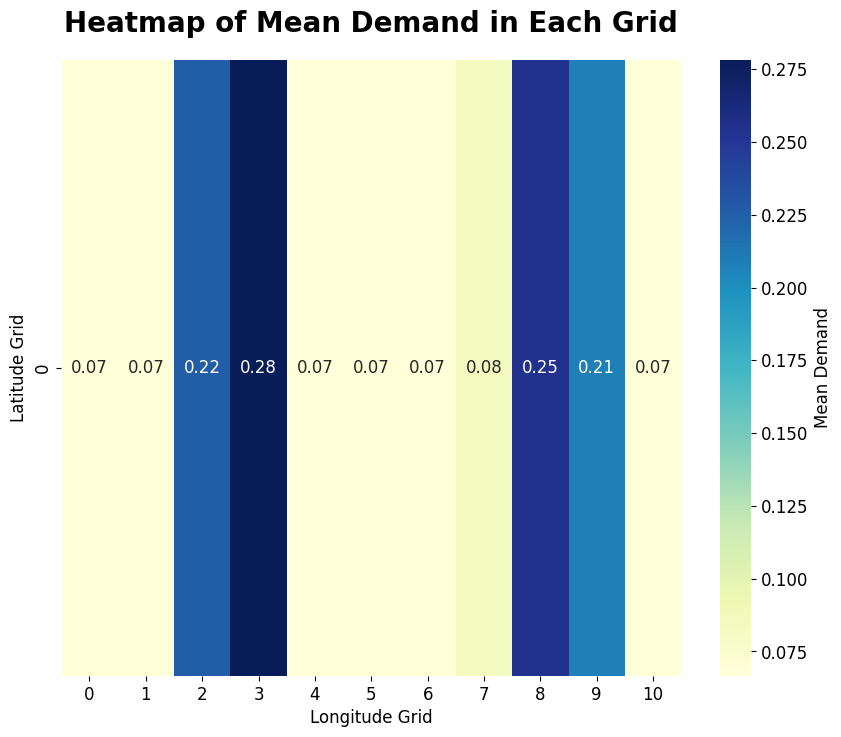

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(mean_demand_matrix, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Mean Demand'}, annot_kws={"size": 12})
plt.title('Heatmap of Mean Demand in Each Grid')
plt.xlabel('Longitude Grid')
plt.ylabel('Latitude Grid')
plt.show()

# Travel time analysis

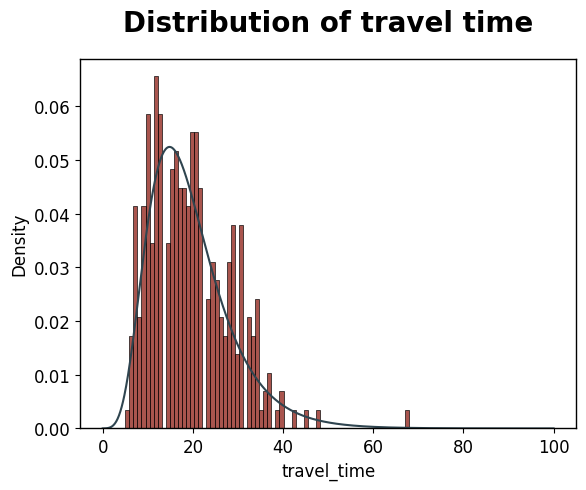

In [19]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["travel_time"])
sns.histplot(df["travel_time"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title("Distribution of travel time")
plt.show()

# Price analysis

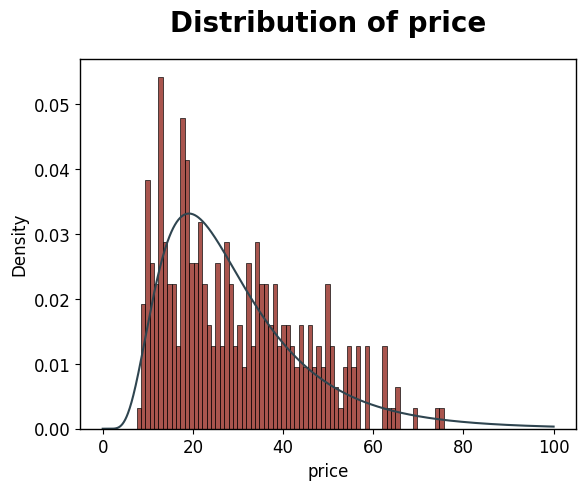

In [20]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["price"])
sns.histplot(df["price"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title("Distribution of price")
plt.show()

In [21]:
df.head()

,time_stamp,origin,destination,demand,travel_time,price
0,1170,6,7,0.133333,16,19.4
1,1170,5,13,0.066667,22,46.8
2,1170,12,6,0.866667,20,35.7
3,1170,5,6,0.600000,34,55.0
4,1170,6,1,0.133333,10,17.8


In [22]:
pred_df = df.copy()

In [23]:
pred_df["poly_travel_time"] = pred_df["travel_time"]**2
pred_df["poly_demand"] = pred_df["demand"]**2
pred_df["log_price"] = np.log(pred_df["price"])

In [26]:
glm_model = smf.glm(formula="log_price ~ travel_time + demand", data=pred_df, family=sm.families.Gaussian())

In [27]:
fitted_glm = glm_model.fit()

In [38]:
fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              log_price   No. Observations:                 4830
Model:                            GLM   Df Residuals:                     4827
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                        0.085573
Method:                          IRLS   Log-Likelihood:                -914.98
Date:                Mon, 30 Oct 2023   Deviance:                       413.06
Time:                        15:32:09   Pearson chi2:                     413.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9123
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2544      0.011    204.589      0.000       2.233       2.276
travel_time     0.0514      0.000    107.782      0.000       0.050       0.052
demand         -0.0172      0.016     -1.101      0.271      -0.048       0.013
===============================================================================
"""

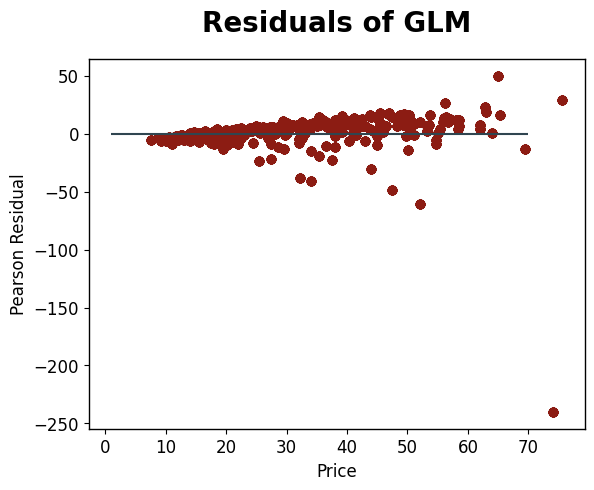

In [39]:
plt.scatter(np.exp(pred_df["log_price"]), np.exp(pred_df["log_price"]) - np.exp(fitted_glm.predict()))
plt.hlines(y=0, xmin=1, xmax=70, color="#2F4550")
plt.xlabel("Price")
plt.ylabel("Pearson Residual")
plt.title("Residuals of GLM")
plt.show()